# Libraries

In [1]:
import pandas as pd
import spacy
from tqdm import tqdm
import os
import math
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
import torchvision
from torchvision import models, transforms
# from transformers import ViTModel, ViTFeatureExtractor

In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
ENVIRON = "LOCAL"
CONFIG = {
    "LOCAL" : {
        "DF_PATH": "data/results.csv",
        "IMAGES_DIR_ROOT": "data",
        "FEATURE_MAPS_PATH": "feature_maps",
    },
    "KAGGLE" : {
        "DF_PATH": "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv",
        "IMAGES_DIR_ROOT": "/kaggle/input/flickr-image-dataset/flickr30k_images",
        "FEATURE_MAPS_PATH": "/kaggle/input/feature-maps"
    }
}

# Hyper Parameters

In [5]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

# Model
N_HEADS = 8
N_LAYERS = 12
EMBED_DIM = 512

# Data Processing

In [6]:
DF_PATH = CONFIG[ENVIRON]["DF_PATH"]
df = pd.read_csv(DF_PATH, delimiter="|")

df.dropna(inplace=True)

df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [7]:
df["comment"] = df[" comment"].apply(lambda x: str(x).strip()) \
                             .apply(lambda x: x.lower())
df.head()

,image_name,comment_number,comment,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many...","two young , white males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together .


# Tokenization

In [8]:
captions_list = df["comment"].to_list()
tokens_list = []
docs = list(nlp.pipe(captions_list, n_process=-1))
# for caption in tqdm(captions_list, desc="Vocab Building"):
#     tokens = nlp(caption)
#     tokens = list(map(lambda x: x.text, tokens))
#     vocab.update(tokens)
for doc in tqdm(docs, desc="Document Processing"):
    tokens = [token.text for token in doc]
    tokens_list.append(tokens)
df["tokens"] = tokens_list

Document Processing: 100%|██████████| 158914/158914 [00:01<00:00, 147619.92it/s]


In [9]:
caption_length = df["tokens"].apply(lambda x: len(x))
max_len = 35
bool_map = (caption_length <= max_len)
print("No. of rows -", df[bool_map].shape[0])
df = df[bool_map].reset_index(drop=True)

No. of rows - 158031


# Vocabulary

In [10]:
vocab = set()
tokens_list = df["tokens"].to_list()
for tokens in tqdm(tokens_list, desc="Vocab Building"):
    vocab.update(tokens)

Vocab Building: 100%|██████████| 158031/158031 [00:00<00:00, 996092.84it/s]


In [11]:
START_TOKEN = "</start>"
END_TOKEN = "</end>"
PAD_TOKEN = "</pad>"

vocab.add(START_TOKEN)
vocab.add(END_TOKEN)
vocab.add(PAD_TOKEN)

vocab = sorted(list(vocab)) # Just incase
vocab_size = len(vocab)

print("Vocab Size -", vocab_size)

Vocab Size - 18222


In [12]:
token_to_idx = {token: i for i, token in enumerate(vocab)}
idx_to_token = {v: k for k, v in token_to_idx.items()}

In [13]:
# max_len += 2 # # +2 due to START and END tokens
max_len = 37 # +2 due to START and END tokens

In [14]:
# df.drop(columns=["comment_number", "comment"], inplace=True)
df["tokens"] = df["tokens"].apply(lambda x: [START_TOKEN, ] + x + [END_TOKEN, ])
df["tokens"] = df["tokens"].apply(lambda x: x + [PAD_TOKEN, ] * (max_len - len(x)))
df.head()

,image_name,comment_number,comment,comment,tokens
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guys with shaggy hair look at their ...,"[</start>, two, young, guys, with, shaggy, hai..."
1,1000092795.jpg,1,"Two young , White males are outside near many...","two young , white males are outside near many ...","[</start>, two, young, ,, white, males, are, o..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard .,"[</start>, two, men, in, green, shirts, are, s..."
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden .,"[</start>, a, man, in, a, blue, shirt, standin..."
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friends enjoy time spent together .,"[</start>, two, friends, enjoy, time, spent, t..."


# Dataset & DataLoader

In [15]:
# df = df.sample(frac=.05).reset_index(drop=True)

In [16]:
def get_train_test_split(df, test_size):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
    
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    return train_df, val_df
train_df, val_df = get_train_test_split(df, test_size=.2)

#### Old Implementation - Ignore (Don't Remove)

In [17]:
# class CaptionsDataset(Dataset):
#     def __init__(self, df, token_to_idx, image_transforms):
#         self.df = df
#         self.token_to_idx = token_to_idx
#         self.image_transforms = image_transforms
#         resnet = models.resnet18(pretrained=True)
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])
#     def __len__(self):
#         return len(self.df)
#     def _encode_tokens(self, tokens):
#         return [self.token_to_idx[token] for token in tokens]
#     def _get_image_features(self, x):
#         with torch.no_grad():
#             image_features = self.resnet(x.unsqueeze(0))
#         return image_features.squeeze()
#     def __getitem__(self, i):
#         image_name, tokens = self.df.loc[i, "image_name"], self.df.loc[i, "tokens"]
#         target_tokens = tokens[1:] + [PAD_TOKEN, ]
#         image_path = os.path.join("data", "flickr30k_images", image_name)
#         image = Image.open(image_path)
#         image = self.image_transforms(image)
#         tokens = self._encode_tokens(tokens)
#         target_tokens = self._encode_tokens(target_tokens)
#         tokens = torch.tensor(tokens, dtype=torch.long)
#         target_tokens = torch.tensor(target_tokens, dtype=torch.long)
#         image_features = self._get_image_features(image)
#         return image_features, tokens, target_tokens

In [18]:
# train_dataset = CaptionsDataset(train_df, token_to_idx, transform)
# val_dataset = CaptionsDataset(val_df, token_to_idx, transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# a, b, c = next(iter(train_loader))
# a.size(), b.size(), c.size()

#### New Implementation

In [19]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [20]:
resnet_model = models.resnet34(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-2]).to(device)

def get_feature_map(x):
    if x.ndimension() == 3:
        x = x.unsqueeze(0)
    with torch.no_grad():
        feature_map = resnet_model(x.to(device))
    if feature_map.ndimension() == 4:
        feature_map = feature_map.squeeze()
    feature_map = feature_map.permute(1, 2, 0)
    channels_size = feature_map.size()[-1]
    feature_map = feature_map.view(1, -1, channels_size)
    return feature_map

    
# vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    
# def get_feature_map(x):
#     if x.ndimension() == 3:
#         x = x.unsqueeze(0)
#     with torch.no_grad():
#         inputs = vit_feature_extractor(images=x, return_tensors="pt")
#         outputs = vit_model(**inputs)
#     features = outputs.last_hidden_state
#     return features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]


In [21]:
import pickle
image_names = set(df["image_name"].to_list())
feature_maps = {}
for image_name in tqdm(image_names, desc="ResNet Feature Maps"):
    image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
    image = Image.open(image_path)
    image = transform(image)
    feature_map = get_feature_map(image)
    feature_maps[image_name] = feature_map
# feature_map_path = os.path.join("resnet18-long-seq")
# with open(feature_map_path, "wb") as f:
#     pickle.dump(feature_maps, f)

# import pickle
# image_names = set(df["image_name"].to_list())
# feature_maps = {}
# for image_name in tqdm(image_names, desc="ViT Feature Extractor"):
#     image_path = os.path.join("data", "flickr30k_images", image_name)
#     image = Image.open(image_path)
#     image = transform(image)
#     feature_map = get_feature_map(image)
#     feature_maps[image_name] = feature_map

ResNet Feature Maps: 100%|██████████| 31783/31783 [09:25<00:00, 56.24it/s]


In [22]:
class CaptionsDataset(Dataset):
    def __init__(self, df, token_to_idx, feature_maps=None):
        
        self.df = df
        self.token_to_idx = token_to_idx
        self.feature_maps = feature_maps
        
    def __len__(self):
        return len(self.df)
    def _encode_tokens(self, tokens):
        return [self.token_to_idx[token] for token in tokens]
    def _process_image(self, image_name):
        image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
        image = Image.open(image_path)
        image = transform(image)
        image_features = get_feature_map(image)
        return image_features
    def __getitem__(self, i):
        image_name, tokens = self.df.loc[i, "image_name"], self.df.loc[i, "tokens"]
        target_tokens = tokens[1:] + [PAD_TOKEN, ]
        tokens = self._encode_tokens(tokens)
        target_tokens = self._encode_tokens(target_tokens)
        tokens = torch.tensor(tokens, dtype=torch.long)
        target_tokens = torch.tensor(target_tokens, dtype=torch.long)
        
        if self.feature_maps is not None:
            image_features = self.feature_maps[image_name]
        else:
            image_features = self._process_image(image_name)
        image_features = image_features.squeeze()
        
        return image_features, tokens, target_tokens

In [23]:
# FEATURE_MAPS_FILENAME = os.path.join(CONFIG[ENVIRON]["FEATURE_MAPS_PATH"], "resnet18-long-seq")
# FEATURE_MAPS_FILENAME = os.path.join("resnet18-long-seq")
# feature_maps = pd.read_pickle(FEATURE_MAPS_FILENAME)

In [24]:
def get_datasets(df, token_to_idx, feature_maps):
    train_df, val_df = get_train_test_split(df, test_size=.2)
    train_dataset = CaptionsDataset(train_df, token_to_idx, feature_maps)
    val_dataset = CaptionsDataset(val_df, token_to_idx, feature_maps)
    return train_dataset, val_dataset

def get_dataloaders(df, token_to_idx, feature_maps, batch_size):
    train_dataset, val_dataset = get_datasets(df, token_to_idx, feature_maps)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

# Model Architecture

In [25]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, p=0.1, max_length=max_len):
        super(PositionalEmbedding, self).__init__()
        self.dropout_layer = nn.Dropout(p)
        encoding = torch.zeros(max_length, embed_dim)
        positions = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        scale_factor = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        encoding[:, 0::2] = torch.sin(positions * scale_factor)
        encoding[:, 1::2] = torch.cos(positions * scale_factor)
        encoding = encoding.unsqueeze(0)
        self.register_buffer('encoding', encoding)
    def forward(self, x):
        if self.encoding.size(0) < x.size(0):
            self.encoding = self.encoding.repeat(x.size(0), 1, 1).to(device)

        self.encoding = self.encoding[:x.size(0), :, :]

        x = x + self.encoding

        return self.dropout_layer(x)

In [26]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, n_heads, n_layers, vocab_size, embed_dim):
        super(ImageCaptioningModel, self).__init__()

        self.position_encoder = PositionalEmbedding(embed_dim, 0.1)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=n_heads)
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=n_layers)
        
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.output_layer = nn.Linear(embed_dim, vocab_size)
        
        self._initialize_weights()

    def _initialize_weights(self, param_range=0.1):
        self.embedding.weight.data.uniform_(-param_range, param_range)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-param_range, param_range)

    def _create_masks(self, size, decoder_input):
        
        causal_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        causal_mask = causal_mask.float().masked_fill(causal_mask == 0, float('-inf')).masked_fill(causal_mask == 1, float(0.0))

        pad_mask = decoder_input.float().masked_fill(decoder_input == 0, float(0.0)).masked_fill(decoder_input > 0, float(1.0))
        pad_mask_bool = decoder_input == 0

        return causal_mask, pad_mask, pad_mask_bool

    def forward(self, image_features, decoder_input):

        image_features = image_features.permute(1, 0, 2) # (num_patches, batch_size, embed_dim) or (feature_map_size, batch_size, num_channels)
        
        decoder_input_embed = self.embedding(decoder_input) * math.sqrt(self.embed_dim)
        decoder_input_embed = self.position_encoder(decoder_input_embed)
        
        decoder_input_embed = decoder_input_embed.permute(1, 0, 2)
        causal_mask, pad_mask, pad_mask_bool = self._create_masks(decoder_input.size(1), decoder_input)

        causal_mask = causal_mask.to(device)
        pad_mask = pad_mask.to(device)
        pad_mask_bool = pad_mask_bool.to(device)

        decoder_output = self.decoder(tgt=decoder_input_embed, memory=image_features, tgt_mask=causal_mask, tgt_key_padding_mask=pad_mask_bool)
        
        output = self.output_layer(decoder_output)
        return output, pad_mask

# Training & Validation Loop

In [27]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc="Training")
    for image_features, tokens, target_tokens in progress_bar:

        optimizer.zero_grad()
        
        image_features = image_features.to(device)
        tokens = tokens.to(device)
        target_tokens = target_tokens.to(device)
        
        logits, padding_mask = model(image_features, tokens)
        logits = logits.permute(1, 2, 0)

        loss = criterion(logits, target_tokens)
        loss_masked = torch.mul(loss, padding_mask)

        batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

        progress_bar.set_postfix(batch_loss=batch_loss.item(), refresh=True)

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [28]:
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    progress_bar = tqdm(val_loader, desc="Validation")
    with torch.inference_mode():
        for image_features, tokens, target_tokens in progress_bar:
            
            image_features = image_features.to(device)
            tokens = tokens.to(device)
            target_tokens = target_tokens.to(device)

            logits, padding_mask = model(image_features, tokens)
            logits = logits.permute(1, 2, 0)

            loss = criterion(logits, target_tokens)
            loss_masked = torch.mul(loss, padding_mask)

            batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)

            total_loss += batch_loss.item()

            progress_bar.set_postfix(batch_loss=batch_loss.item(), refresh=True)

    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Model Training

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch : [{epoch + 1}/{num_epochs}]")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = val_epoch(model, val_loader, criterion, device)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, "best_model")
            print("Model saved!")

    print("Training Complete.")

In [30]:
criterion = nn.CrossEntropyLoss()

model = ImageCaptioningModel(N_HEADS, N_LAYERS, vocab_size, EMBED_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.3, patience=2)

In [31]:
train_loader, val_loader = get_dataloaders(df, token_to_idx, feature_maps, BATCH_SIZE)

In [32]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS, device)

Epoch : [1/30]


Training:   0%|          | 0/3951 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation: 100%|██████████| 988/988 [00:38<00:00, 25.54it/s, batch_loss=1.43]


Training Loss: 1.8913
Validation Loss: 1.5690
Current Learning Rate: 1e-05
Model saved!
Epoch : [2/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.49it/s, batch_loss=1.32]


Training Loss: 1.5149
Validation Loss: 1.4442
Current Learning Rate: 1e-05
Model saved!
Epoch : [3/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.62it/s, batch_loss=1.26]


Training Loss: 1.4177
Validation Loss: 1.3775
Current Learning Rate: 1e-05
Model saved!
Epoch : [4/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.57it/s, batch_loss=1.21]


Training Loss: 1.3549
Validation Loss: 1.3323
Current Learning Rate: 1e-05
Model saved!
Epoch : [5/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.53it/s, batch_loss=1.18]


Training Loss: 1.3077
Validation Loss: 1.2989
Current Learning Rate: 1e-05
Model saved!
Epoch : [6/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.57it/s, batch_loss=1.15]


Training Loss: 1.2698
Validation Loss: 1.2713
Current Learning Rate: 1e-05
Model saved!
Epoch : [7/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.61it/s, batch_loss=1.13]


Training Loss: 1.2372
Validation Loss: 1.2498
Current Learning Rate: 1e-05
Model saved!
Epoch : [8/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.57it/s, batch_loss=1.11]


Training Loss: 1.2085
Validation Loss: 1.2308
Current Learning Rate: 1e-05
Model saved!
Epoch : [9/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.58it/s, batch_loss=1.09]


Training Loss: 1.1820
Validation Loss: 1.2150
Current Learning Rate: 1e-05
Model saved!
Epoch : [10/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.55it/s, batch_loss=1.08]


Training Loss: 1.1576
Validation Loss: 1.2013
Current Learning Rate: 1e-05
Model saved!
Epoch : [11/30]


Validation: 100%|██████████| 988/988 [00:38<00:00, 25.68it/s, batch_loss=1.07]


Training Loss: 1.1345
Validation Loss: 1.1898
Current Learning Rate: 1e-05
Model saved!
Epoch : [12/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 25.07it/s, batch_loss=1.06]


Training Loss: 1.1124
Validation Loss: 1.1789
Current Learning Rate: 1e-05
Model saved!
Epoch : [13/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.75it/s, batch_loss=1.05]


Training Loss: 1.0913
Validation Loss: 1.1709
Current Learning Rate: 1e-05
Model saved!
Epoch : [14/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.75it/s, batch_loss=1.04]


Training Loss: 1.0704
Validation Loss: 1.1624
Current Learning Rate: 1e-05
Model saved!
Epoch : [15/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.77it/s, batch_loss=1.03]


Training Loss: 1.0506
Validation Loss: 1.1546
Current Learning Rate: 1e-05
Model saved!
Epoch : [16/30]


Validation: 100%|██████████| 988/988 [00:40<00:00, 24.63it/s, batch_loss=1.03]


Training Loss: 1.0309
Validation Loss: 1.1486
Current Learning Rate: 1e-05
Model saved!
Epoch : [17/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.71it/s, batch_loss=1.03]


Training Loss: 1.0116
Validation Loss: 1.1431
Current Learning Rate: 1e-05
Model saved!
Epoch : [18/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.80it/s, batch_loss=1.03]


Training Loss: 0.9923
Validation Loss: 1.1396
Current Learning Rate: 1e-05
Model saved!
Epoch : [19/30]


Validation: 100%|██████████| 988/988 [00:40<00:00, 24.61it/s, batch_loss=1.02]


Training Loss: 0.9739
Validation Loss: 1.1358
Current Learning Rate: 1e-05
Model saved!
Epoch : [20/30]


Validation: 100%|██████████| 988/988 [00:40<00:00, 24.57it/s, batch_loss=1.01]


Training Loss: 0.9556
Validation Loss: 1.1326
Current Learning Rate: 1e-05
Model saved!
Epoch : [21/30]


Validation: 100%|██████████| 988/988 [00:40<00:00, 24.55it/s, batch_loss=1.01]


Training Loss: 0.9378
Validation Loss: 1.1298
Current Learning Rate: 1e-05
Model saved!
Epoch : [22/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.76it/s, batch_loss=1]


Training Loss: 0.9200
Validation Loss: 1.1281
Current Learning Rate: 1e-05
Model saved!
Epoch : [23/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.79it/s, batch_loss=1]


Training Loss: 0.9029
Validation Loss: 1.1262
Current Learning Rate: 1e-05
Model saved!
Epoch : [24/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.78it/s, batch_loss=1]


Training Loss: 0.8855
Validation Loss: 1.1236
Current Learning Rate: 1e-05
Model saved!
Epoch : [25/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.76it/s, batch_loss=0.995]


Training Loss: 0.8690
Validation Loss: 1.1250
Current Learning Rate: 1e-05
Epoch : [26/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.72it/s, batch_loss=0.996]


Training Loss: 0.8526
Validation Loss: 1.1244
Current Learning Rate: 1e-05
Epoch : [27/30]


Validation: 100%|██████████| 988/988 [00:40<00:00, 24.68it/s, batch_loss=1]


Training Loss: 0.8362
Validation Loss: 1.1255
Current Learning Rate: 3e-06
Epoch : [28/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.72it/s, batch_loss=0.995]


Training Loss: 0.8107
Validation Loss: 1.1186
Current Learning Rate: 3e-06
Model saved!
Epoch : [29/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.78it/s, batch_loss=0.993]


Training Loss: 0.8035
Validation Loss: 1.1190
Current Learning Rate: 3e-06
Epoch : [30/30]


Validation: 100%|██████████| 988/988 [00:39<00:00, 24.78it/s, batch_loss=0.994]

Training Loss: 0.7981
Validation Loss: 1.1192
Current Learning Rate: 3e-06
Training Complete.


In [33]:
def generate_caption(K, image_name):
    
    image_path = os.path.join(CONFIG[ENVIRON]["IMAGES_DIR_ROOT"], "flickr30k_images", image_name)
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)

    model.eval()
    feature_map = feature_maps[image_name].to(device)


    input_tokens = [token_to_idx[PAD_TOKEN]] * max_len
    input_tokens[0] = token_to_idx[START_TOKEN]

    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)
    predicted_sentence = []
    
    with torch.no_grad():
        for eval_iter in range(0, max_len-1):

            logits, padding_mask = model.forward(feature_map, input_tokens)

            logits = logits[eval_iter, 0, :]

            values = torch.topk(logits, K).values.tolist()
            indices = torch.topk(logits, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = idx_to_token[next_word_index]

            input_tokens[:, eval_iter+1] = next_word_index


            if next_word == '</end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence))

In [34]:
model = torch.load("best_model").to(device)

/tmp/ipykernel_23/1491680750.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model").to(device)


In [35]:
i = 0



Predicted caption : 
a group of children playing on a playground .


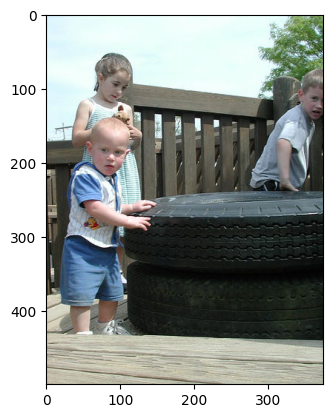

In [36]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a young boy in swimming trunks is in the water at the beach .


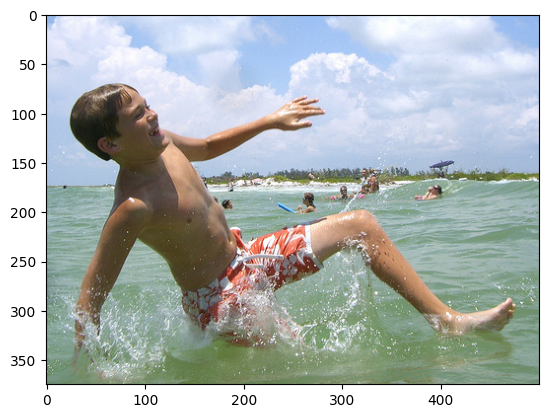

In [37]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a little girl is walking on a balance beam .


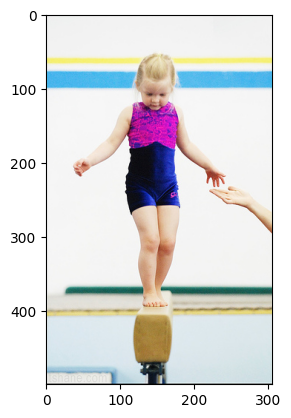

In [38]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a woman sits on a bench next to a child who is holding a green and white umbrella .


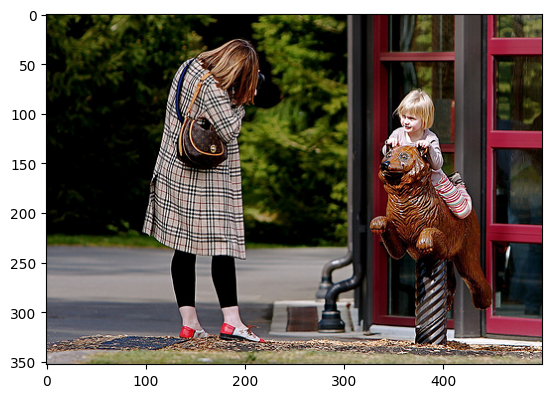

In [39]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a group of young people are sitting on a bench and watching a woman in a red sweater play a board game .


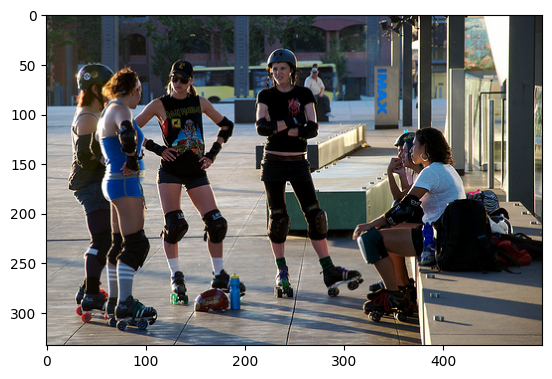

In [40]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a black and white dog jumping in the air .


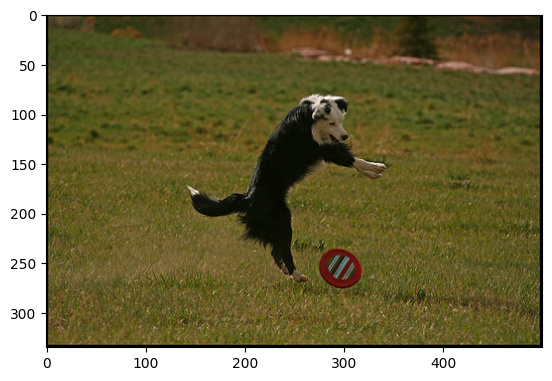

In [41]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])



Predicted caption : 
a man in a brown jacket is sitting on a chair with his head down .


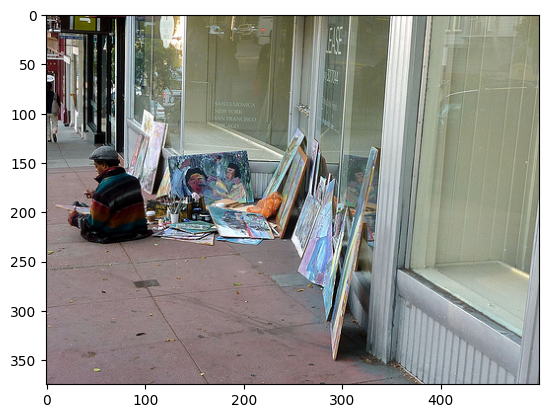

In [42]:
i += 1
generate_caption(K=1, image_name=val_df.loc[i, "image_name"])